# jpath

Full working example demonstrating the features of ``cspy``.

## Problem Description

Jane is part-time postwoman working in Delft, Netherlands. However, she is assigned a small area (the Indische Buurt neighbourhood) so when planning her daily route she wants to make it as long and exciting as possible. 
That is, when planning her routes she has to consider the total shift time, sights visited, travel time, and delivery time. Her shift has to be at most 5 hours.


This problem can easily be modelled as a CSP problem. 
With the description above, the set of resources can be defined as,

In [1]:
R = ['mono', 'sights', 'shift', 'travel-time', 'delivery-time'] 
# len(R) = 5

Let ``G`` denote a directed graph with edges to/from all streets of the Indische Buurt neighbourhood. Each edge has an attribute ``weight`` proportional to the distance (in km) between the two nodes and an attribute ``res_cost`` which is an array (specifically, a ``numpy.array``) with length ``len(R)``. To maximise the distance of the path, as required by Jane, we simple negate the distance, hence, solving a shortest path problem with negative distance will be the equivalent to solving a longest path problem. The entries of ``res_cost`` have the same order as the entries in ``R``.
The first entry of this array, corresponds to the ``'sights'`` resource, i.e. how many sights there are along a specific edge. The last entry of this array, corresponds to the ``'delivery-time'`` resource, i.e. time taken to deliver post along a specific edge. The remaining entries can be initialised to be 0.
Also, when defining ``G``, one has to specify the number of resources ``n_res``, which also has to be equal to ``len(R)``.

Now, using the open source package OSMnx, we can easily generate a network for Jane's neighbourhood

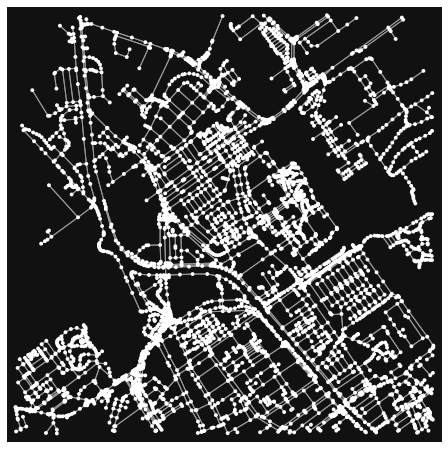

In [2]:
from osmnx import graph_from_address, plot_graph

M = graph_from_address('Ceramstraat, Delft, Netherlands',
                        network_type='walk',
                        simplify=False)
f, ax = plot_graph(M)

We have to transform the network for one compatible with cspy.

In [3]:
from networkx import DiGraph
from jpath_preprocessing import relabel_source_sink, add_cspy_edge_attributes

# Transform M to comply with cspy's prerequirements
# Convert MultiGraph into a Digraph with attribute 'n_res'
G = DiGraph(M, directed=True, n_res=5)
# Relabel source node to "Source" and sink node to "Sink" (see function for more details)
G = relabel_source_sink(G)
# Add res_cost and other resource attributes (see function for more details)
G = add_cspy_edge_attributes(G)

n_edges = len(G.edges())  # number of edges in network

print(n_edges)

9962


To define the custom REFs,  ``jane_REF``, that controls how resources evolve throughout the path, we require two inputs: an array of current cumulative resource values ``res``, and the edge that is being considered for an extension of a path ``edge`` (which consists of two nodes and the edge data).

In [4]:
from numpy import array
from cspy import REFCallback

class MyCallback(REFCallback):

    def __init__(self):
        REFCallback.__init__(self)
        # Empty attribute for later 
        self.G = None

    def REF_fwd(self, cumul_res, tail, head, edge_res, partial_path,
                cumul_cost):
        new_res = list(cumul_res)
        i, j = tail, head
        # Monotone resource
        new_res[0] += 1
        # Update 'sights' resource
        new_res[1] += self.G.edges[i,j]['res_cost'][1]
        # Extract the 'travel-time' resource (distance/speed)
        new_res[3] = - self.G.edges[i,j]['weight'] / float(WALKING_SPEED)
        # # Update 'delivery-time' resource
        new_res[4] = self.G.edges[i,j]['res_cost'][4]
        # # Update 'shift' resource
        new_res[2] += (new_res[3] + new_res[4])  # travel-time + delivery-time
        return new_res

Using ``cspy``, Jane can compute a route subject to her constraints as,


In [5]:
from cspy import Tabu, BiDirectional

WALKING_SPEED = 3

# Recall 
#     R = ['mono', 'sights', 'shift', 'travel-time', 'delivery-time'] 
max_res = [n_edges, 5*n_edges, 5, 5, 5]
min_res = [0, 0, 0, 0, 0]

my_callback = MyCallback()

alg1 = BiDirectional(G, max_res, min_res, REF_callback=my_callback, direction="forward", elementary=True)
# Pass preprocessed graph
my_callback.G = alg1.G
alg1.run()
print(alg1.path)
print(alg1.total_cost)
print(alg1.consumed_resources)

['Source', 8689149668, 44896906, 44896436, 44895558, 44894640, 44893327, 2596819756, 44891913, 44891422, 3170421827, 3170421825, 44890549, 3669218091, 3669218090, 2461552435, 44888943, 44886328, 3170422570, 8689456246, 315119898, 44883809, 44883808, 4798917165, 265529545, 44883803, 7618128151, 321676832, 44884116, 4969008387, 390922809, 44884858, 44886817, 44887679, 44889787, 44890986, 295459206, 44894212, 44896901, 'Sink']
0.0
[39.0, 83.0, 2.0525655138215217, 0.0, 0.2503379330024114]
